In [21]:
import os
from pathlib import Path
import pandas as pd

data_path = "../data/sims/"

files = [Path(data_path)/f for f in os.listdir(data_path) if f.startswith("acoustic_results_subj")]
dfs = []
for f in files:
    dfs.append(pd.read_csv(f))
df = pd.concat(dfs)
df = df.reset_index(drop=True)
df.sample(5)

,Row,sub_id,skin,skull,brain,brain_inner,targetL,targetR,ROItarget_L_max,ROItarget_R_max,ROItarget_L_avg,ROItarget_R_avg
8,intensity_L+z--r_R+z--r_all_phases,5,106.88650,18.41045,22.33810,22.00432,0.068615,2.736102,13.63289,22.00432,6.148567,9.761615
5,intensity_L+z--l_R+z--l_all_phases,3,45.84959,27.71434,24.34999,24.34999,7.351885,13.527760,19.00974,15.22334,8.849524,6.003909
10,intensity_L--r_R--r_all_phases,6,99.73326,12.22669,28.35506,28.35506,1.059724,1.574258,16.47923,24.04913,7.802211,11.743520
1,intensity_L+z--l_R+z--l_all_phases,1,284.59810,128.86050,104.55390,104.55390,24.889420,25.568160,82.90151,27.83399,40.737840,12.181090
3,intensity_L+z--l_R+z--l_all_phases,2,365.59130,195.26060,110.28140,110.28140,74.040140,22.668150,89.93999,37.32933,43.869300,14.627490


In [22]:
# clean the data: add more rows & make sure everything is balanced

# add variable if 0 (bilateral), target left (-1), target right (1)
import re

def get_dir(s):
    if bool(re.search(r"L.*--l.*R.*--r", s)): return "bilateral"
    if bool(re.search(r"L.*--l.*R.*--l", s)): return "unilateral left"
    if bool(re.search(r"L.*--r.*R.*--r", s)): return "unilateral right"
    return 999

df["dir"] = [get_dir(s) for s in df["Row"]]
df.sample(5)

,Row,sub_id,skin,skull,brain,brain_inner,targetL,targetR,ROItarget_L_max,ROItarget_R_max,ROItarget_L_avg,ROItarget_R_avg,dir
10,intensity_L--r_R--r_all_phases,6,99.73326,12.22669,28.35506,28.35506,1.059724,1.574258,16.47923,24.04913,7.802211,11.743520,unilateral right
0,intensity_L+z--r_R+z--r_all_phases,1,35.29919,18.50459,16.66025,16.66025,6.273850,8.295021,11.92226,16.52233,5.144731,6.737848,unilateral right
1,intensity_L+z--l_R+z--l_all_phases,1,284.59810,128.86050,104.55390,104.55390,24.889420,25.568160,82.90151,27.83399,40.737840,12.181090,unilateral left
3,intensity_L+z--l_R+z--l_all_phases,2,365.59130,195.26060,110.28140,110.28140,74.040140,22.668150,89.93999,37.32933,43.869300,14.627490,unilateral left
9,intensity_L+z--l_R+z--l_all_phases,5,261.34880,164.44390,111.64940,111.64940,33.358230,8.147796,84.89126,24.33015,47.341820,11.533970,unilateral left


In [23]:
# make separate tables for output vars

# Split into 3 DataFrames based on keyword in "Row"
df_pressure         = df[df["Row"].str.contains("pressure")]
df_intensity        = df[df["Row"].str.contains("intensity")]
df_mechanicalindex  = df[df["Row"].str.contains("mechanicalindex")]

df_intensity.sample(5)

,Row,sub_id,skin,skull,brain,brain_inner,targetL,targetR,ROItarget_L_max,ROItarget_R_max,ROItarget_L_avg,ROItarget_R_avg,dir
3,intensity_L+z--l_R+z--l_all_phases,2,365.59130,195.26060,110.28140,110.28140,74.040140,22.668150,89.93999,37.32933,43.869300,14.627490,unilateral left
11,intensity_L--l_R--l_all_phases,6,358.47790,259.77910,206.44990,206.44990,39.739830,1.909860,113.73520,34.65366,63.797450,14.783910,unilateral left
6,intensity_L+z--r_R+z--r_all_phases,4,50.30119,14.86093,28.05627,28.05627,1.328331,9.482297,19.52331,23.38966,7.642339,10.293810,unilateral right
1,intensity_L+z--l_R+z--l_all_phases,1,284.59810,128.86050,104.55390,104.55390,24.889420,25.568160,82.90151,27.83399,40.737840,12.181090,unilateral left
7,intensity_L+z--l_R+z--l_all_phases,4,391.43690,460.58160,193.98630,193.98630,40.528200,5.874068,90.14832,14.24385,42.874990,6.089571,unilateral left


In [24]:
def restructure_to_long(df_):
    # Step 1: Select only the relevant columns
    df_ = df_[['Row', 'sub_id', 'targetL', 'targetR', 'ROItarget_L_max', 'ROItarget_R_max', 'ROItarget_L_avg', 'ROItarget_R_avg', 'dir']]

    # Step 2: Rename columns to have consistent suffixes ('_L' and '_R')
    df_ = df_.rename(columns={
        'targetL': 'target_L',
        'targetR': 'target_R',
        'ROItarget_L_max': 'ROItarget_max_L',
        'ROItarget_R_max': 'ROItarget_max_R',
        'ROItarget_L_avg': 'ROItarget_avg_L',
        'ROItarget_R_avg': 'ROItarget_avg_R'
    })

    # Step 3: Melt the DataFrame to long format
    id_vars = ['Row', 'sub_id', 'dir']
    value_vars = [col for col in df_.columns if col not in id_vars]
    df_long = pd.melt(df_, id_vars=id_vars, value_vars=value_vars, var_name='variable', value_name='value')

    # Step 4: Extract the variable names and 'Side' (L/R) from the 'variable' column
    df_long[['variable_name', 'Side']] = df_long['variable'].str.rsplit('_', n=1, expand=True)

    # Step 5: Pivot the DataFrame to get variables as columns
    df_long = df_long.pivot_table(index=['Row', 'sub_id', 'Side', 'dir'], columns='variable_name', values='value').reset_index()

    # Optional: Reorder columns if necessary
    df_long = df_long[['Row', 'sub_id', 'Side', 'target', 'ROItarget_avg', 'ROItarget_max', 'dir']]

    # Now 'df_long' is your DataFrame in long format
    return df_long


In [25]:
# df_p_long = restructure_to_long(df_pressure)
df_i_long = restructure_to_long(df_intensity)
# df_MI_long = restructure_to_long(df_mechanicalindex)
df_i_long.sample(6)

variable_name,Row,sub_id,Side,target,ROItarget_avg,ROItarget_max,dir
17,intensity_L+z--r_R+z--r_all_phases,4,R,9.482297,10.293810,23.38966,unilateral right
10,intensity_L+z--r_R+z--r_all_phases,1,L,6.273850,5.144731,11.92226,unilateral right
22,intensity_L--r_R--r_all_phases,6,L,1.059724,7.802211,16.47923,unilateral right
0,intensity_L+z--l_R+z--l_all_phases,1,L,24.889420,40.737840,82.90151,unilateral left
3,intensity_L+z--l_R+z--l_all_phases,2,R,22.668150,14.627490,37.32933,unilateral left
20,intensity_L--l_R--l_all_phases,6,L,39.739830,63.797450,113.73520,unilateral left


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def plot_barscatter(df_, label, DV):

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(4, 4))

    # Plot the barplot without error bars
    sns.barplot(
        data=df_,
        x="dir",
        y=DV,
        hue="Side",
        errorbar=None,  # Remove error bars
        palette="dark",
        alpha=.25,
        ax=ax,
        legend=False
    )

    # Overlay the individual data points using a stripplot
    subjects = sorted(list(set(df_["sub_id"])))
    markers = [".", "s", "+", "x", "d", "*"]
    for marker, subject in zip(markers, subjects):
        sub_df = df_[df_["sub_id"] == subject]
        sns.stripplot(
            data=sub_df,
            x="dir",
            jitter=True,
            y=DV,
            hue="Side",
            dodge=True,
            palette="dark",
            marker=marker,
            s=6,
            alpha=0.6,
            ax=ax,
            legend=False  # Prevent duplicate legends
        )

    # sns.pointplot(
    #     data=df_,
    #     x="dir",
    #     y=DV,
    #     hue="Side",
    #     dodge=0.4,  # Matches dodge in barplot for side-by-side points
    #     markers='o',
    #     linestyles='-',
    #     palette="dark",
    #     alpha=0.5,
    #     ax=ax,
    #     # estimator=None  # Plot individual data points without aggregation
    # )

    # Adjust the legend to avoid duplicates
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Side")

    # Set the labels
    ax.set_xlabel("")
    ax.set_ylabel(label)

    plt.show()


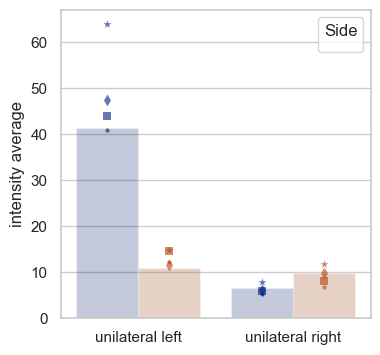

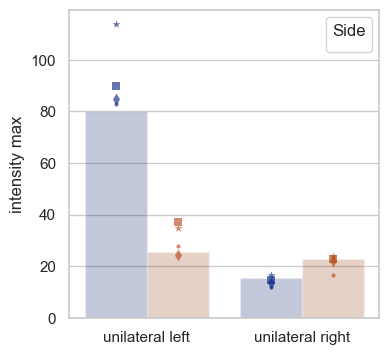

In [27]:
plot_barscatter(df_i_long, "intensity average", "ROItarget_avg")
plot_barscatter(df_i_long, "intensity max", "ROItarget_max")
# plot_barscatter(df_p_long, "pressure average", "ROItarget_avg")
# plot_barscatter(df_p_long, "pressure max", "ROItarget_max")